# How to add static breakpoints
- https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/
- `interrupt_before`

## Simple Usage

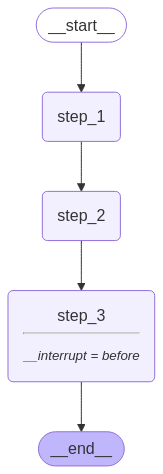

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["step_3"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

try:
    user_approval = input("Do you want to go to Step 3? (yes/no): ")
except:
    user_approval = "yes"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        print(event)
else:
    print("Operation cancelled by user.")

{'input': 'hello world'}
---Step 1---
---Step 2---
{'input': 'hello world'}
---Step 3---


## Agent

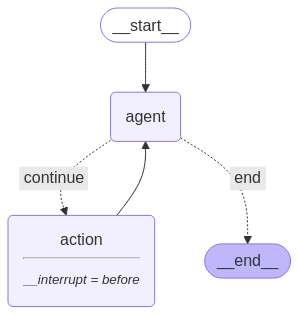

In [3]:
# Set up the tool
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)

# Set up the model

model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
model = model.bind_tools(tools)


# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

display(Image(app.get_graph().draw_mermaid_png()))

Interrupt:

In [4]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "3"}}
inputs = [HumanMessage(content="search for the weather in sf now")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

search for the weather in sf now
================================== Ai Message ==================================

[{'text': "Certainly! I'll search for the current weather in San Francisco for you. Let me use the search function to find this information.", 'type': 'text'}, {'id': 'toolu_011Re7JeTyPBk1dnPJkBcbMn', 'input': {'query': 'current weather in San Francisco'}, 'name': 'search', 'type': 'tool_use'}]
Tool Calls:
  search (toolu_011Re7JeTyPBk1dnPJkBcbMn)
 Call ID: toolu_011Re7JeTyPBk1dnPJkBcbMn
  Args:
    query: current weather in San Francisco


In [9]:
print(app.get_state(thread).next)

('action',)


Resume:

In [10]:
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Certainly! I'll search for the current weather in San Francisco for you. Let me use the search function to find this information.", 'type': 'text'}, {'id': 'toolu_011Re7JeTyPBk1dnPJkBcbMn', 'input': {'query': 'current weather in San Francisco'}, 'name': 'search', 'type': 'tool_use'}]
Tool Calls:
  search (toolu_011Re7JeTyPBk1dnPJkBcbMn)
 Call ID: toolu_011Re7JeTyPBk1dnPJkBcbMn
  Args:
    query: current weather in San Francisco
================================= Tool Message =================================
Name: search

["It's sunny in San Francisco, but you better look out if you're a Gemini 😈."]
================================== Ai Message ==================================

Thank you for waiting. I've searched for the current weather in San Francisco, and here's what I found:

The current weather in San Francisco is sunny. 

It's a beautiful day in the city! The sun is out, which is great 